vartheta = 0.009913251258420805
C_ss = 0.9950124999218759
M_ss = 0.9931486071961776
X_ss = 0.9945464448378508
vartheta = 0.00992552744955505
C_ss = 0.995012499921876
M_ss = 0.9937695165025179
X_ss = 0.9943909111045253
vartheta = 0.009950075743944627
C_ss = 0.9950124999218759
M_ss = 0.9950100124041001
X_ss = 0.9950100148916006
vartheta = 0.009999501274866112
C_ss = 0.995012499921876
M_ss = 0.9975031327880007
X_ss = 1.0000062656347903
vartheta = 0.010098982602851752
C_ss = 0.9950124999218762
M_ss = 1.0025031171631718
X_ss = 1.0264116348453762


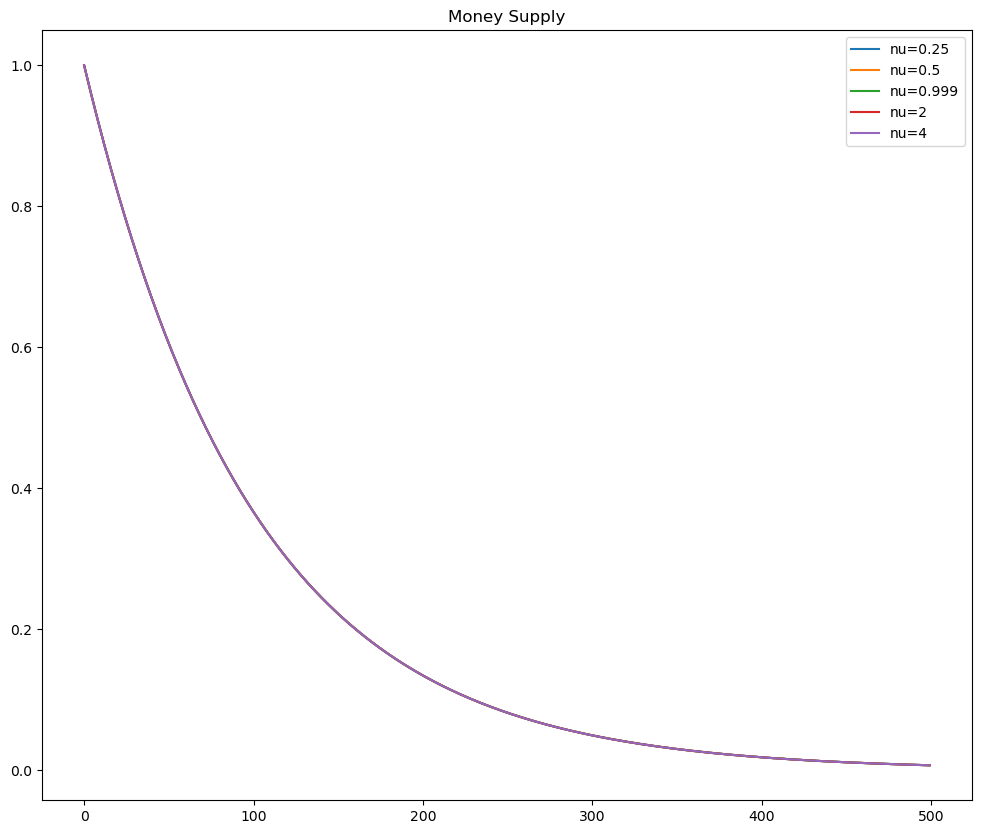

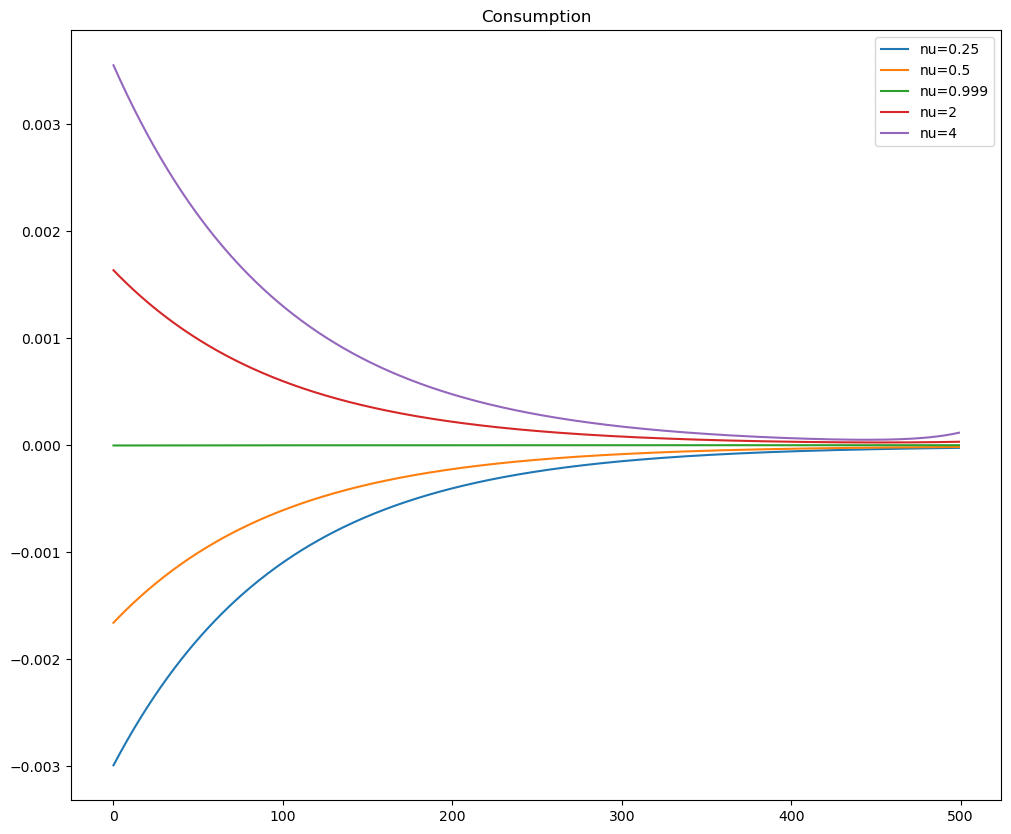

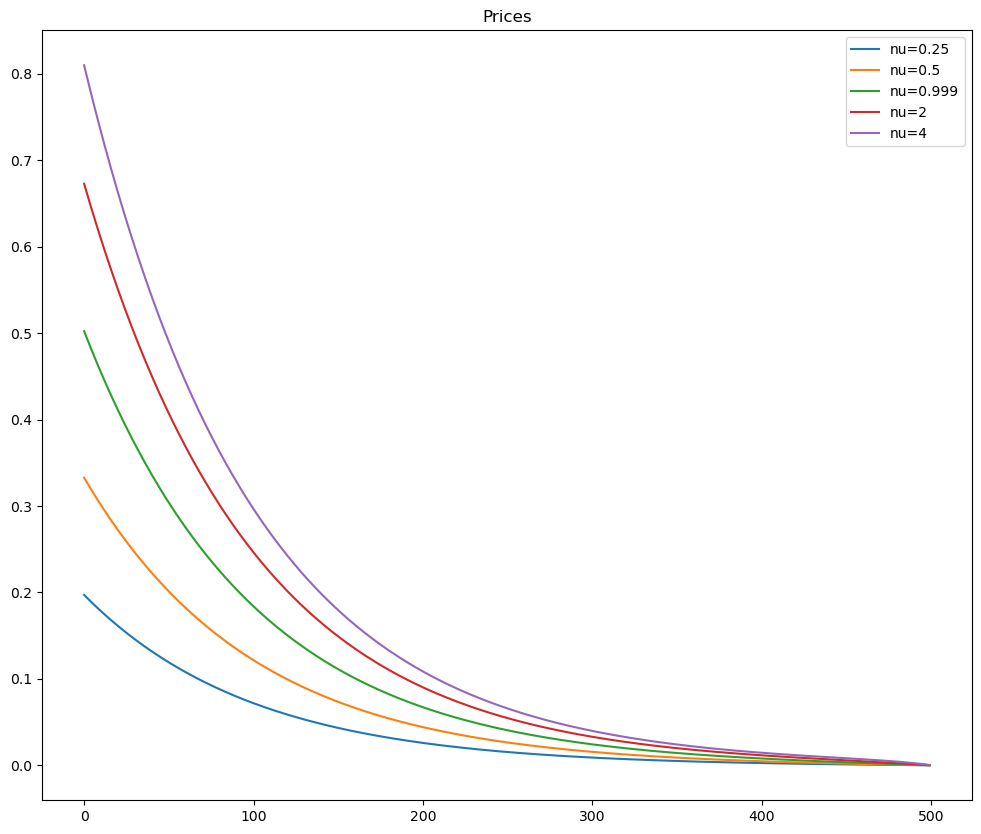

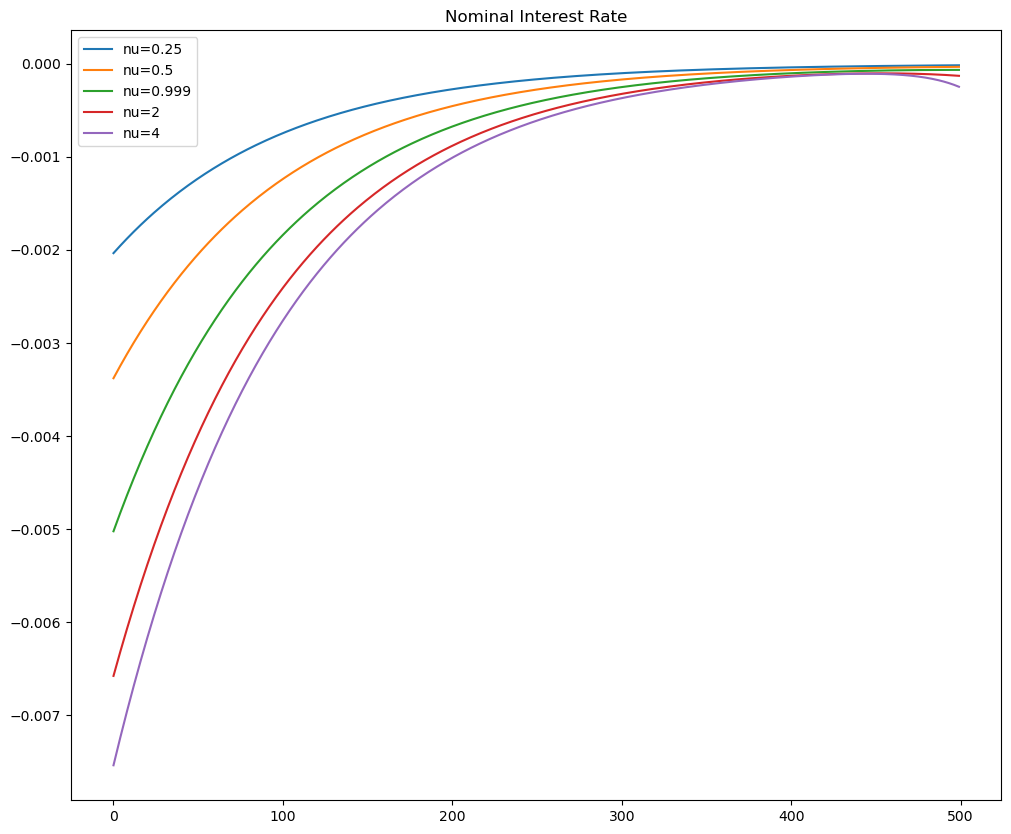

In [4]:
#### Colaborators: Adrian, Natalia, Beatrice, David
# Load modules for very interesting macroeconomics models
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# plot impulse response functions
fig1, Ax1 = plt.subplots(figsize=(12, 10))
fig2, Ax2 = plt.subplots(figsize=(12, 10))
fig3, Ax3 = plt.subplots(figsize=(12, 10))
fig4, Ax4 = plt.subplots(figsize=(12, 10))

for x in [0.25, 0.5, 0.999, 2, 4]:
    # Set parameters
    gamma = 1
    varphi = 1
    chi = 1
    nu = x
    beta = 0.99
    rho_m = 0.99
    A = 1 # productivity
    T = 500

    # Calculate vartheta
    vartheta = (1 - beta) / ((1 - beta) + ((-(1 - beta) + np.sqrt(beta**2 - 2*beta + 5)) / 2)**nu)

    print("vartheta =", vartheta)

    # Consumption, X, price and money Steady State
    c_ss = (
        chi**(-1/(nu - gamma)) *
        (1 - vartheta)**(1/(nu - gamma)) *
        (
            (1 - vartheta) +
            vartheta**(1/nu) *
            ((1 / ((1 - vartheta) * (1 - beta)))**((1 - nu) / nu))
        )**(1/(1 - nu))
    )**((nu - gamma) / (varphi + gamma))

    p_ss = 1

    m_ss = (
        (vartheta / ((1 - vartheta) * (1 - beta)))**(1/nu) *
        chi**(-1/(nu - gamma)) *
        (1 - vartheta)**(1/(nu - gamma)) *
        (
            (1 - vartheta) +
            vartheta**(1/nu) *
            ((1 / ((1 - vartheta) * (1 - beta)))**((1 - nu) / nu))
        )**(1/(1 - nu))
    )**((nu - gamma) / (varphi + gamma))

    x_ss = ((1 - nu) * c_ss**(1 - nu) + nu * (m_ss / p_ss)**(1 - nu))**(1/(1-nu))

    print("C_ss =", c_ss)
    print("M_ss =", m_ss)
    print("X_ss =", x_ss)
    #### Market Clearing Block
    # define sparse identity, above-diagonal sparse matrix, below-diagonal sparse matrix, and zero matrix
    I = sp.sparse.eye(T)
    Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T))
    Z = sp.sparse.csr_matrix((T, T))

    # Good Market
    Phigmy = -I
    Phigmwp = Z
    Phigmmp = Z
    Phigmc = I
    Phigmx = Z
    Phigmq = Z

    # Money Market
    Phimmy = Z
    Phimmwp = Z
    Phimmmp = -I
    Phimmc = I
    Phimmx = Z
    Phimmq = -(1/nu)*(beta/(1-beta))*I

    dHdY = sp.sparse.bmat([[Phigmy, Phigmwp, Phigmmp, Phigmc, Phigmx, Phigmq],
                        [Phimmy, Phimmwp, Phimmmp, Phimmc, Phimmx, Phimmq]])


    assert dHdY.shape == (2*T, 6*T)
    #### Firm block
    #Production
    Phiyn = I
    Phiyp = Z
    Phiym = Z

    #Labor demand
    Phiwpn = Z
    Phiwpp = Z
    Phiwpm = Z
    
    #MP Identity
    Phimpn = Z
    Phimpm = I
    Phimpp = -I

    dFYdU = sp.sparse.bmat([[Phiyn, Phiyp],
                        [Phiwpn, Phiwpp],
                           [Phimpn, Phimpp]])
    dFYdZ = sp.sparse.bmat([[Phiym],
                        [Phiwpm],
                           [Phimpm]])

    assert dFYdU.shape == (3*T, 2*T)
    assert dFYdZ.shape == (3*T, 1*T)

    #### Household Block
    A = (nu - (nu - gamma)*(1-vartheta)*(c_ss/x_ss)**(1-nu))**(-1)

    # Consumption thing
    Phicn = A*Phiwpn - A*varphi*I
    Phicp = A*(Phiwpp - (nu-gamma)*vartheta*(m_ss/(p_ss*x_ss))**(1-nu)*I)
    Phicm = A*(nu-gamma)*vartheta*(m_ss/(p_ss*x_ss))**(1-nu)*I

    dCYdU = sp.sparse.bmat([[Phicn, Phicp]])
    dCYdZ = sp.sparse.bmat([[Phicm]])

    assert dCYdU.shape == (1*T, 2*T)
    assert dCYdZ.shape == (1*T, 1*T)

    # X thing
    Phixn = (1-vartheta)*(c_ss/x_ss)**(1-nu)*Phicn
    Phixp = (1-vartheta)*(c_ss/x_ss)**(1-nu)*Phicp + vartheta*(m_ss/(p_ss*x_ss))**(1-nu)*I
    Phixm = (1-vartheta)*(c_ss/x_ss)**(1-nu)*Phicm + vartheta*(m_ss/(p_ss*x_ss))**(1-nu)*I

    dXYdU = sp.sparse.bmat([[Phixn, Phixp]])
    dXYdZ = sp.sparse.bmat([[Phixm]])

    assert dXYdU.shape == (1*T, 2*T)
    assert dXYdZ.shape == (1*T, 1*T)

    # Bond Block... the last one, I hope
    Phiqn = -nu*(Phicn*I - Phicn*Ip1) + (nu-gamma)*(Phixn*I - Phixn*Ip1)
    Phiqp = -nu*Phicp*(I - Ip1) - (I - Ip1) + (nu - gamma)*(Phixp*I - Phixp*Ip1)
    Phiqm = -nu*(Phicm*I - Phicm*Ip1) + (nu-gamma)*(Phixm*I - Phixm*Ip1)

    dBYdU = sp.sparse.bmat([[Phiqn, Phiqp]])
    dBYdZ = sp.sparse.bmat([[Phiqm]])
    assert dBYdU.shape == (1*T, 2*T)
    assert dBYdZ.shape == (1*T, 1*T)
    # stack to get dYdU
    dYdU = sp.sparse.bmat([[dFYdU],
                        [dCYdU],
                        [dXYdU],
                        [dBYdU]])

    # stack to get dYdZ
    dYdZ = sp.sparse.bmat([[dFYdZ],
                        [dCYdZ],
                        [dXYdZ],
                        [dBYdZ]])

    assert dYdU.shape == (6*T, 2*T)
    assert dYdZ.shape == (6*T, 1*T)
    # compute dHdU using the chain rule dHdU = dHdY @ dYdU (@ is the python matrix multiplication operator)
    dHdU = dHdY @ dYdU

    # compute dHdZ using the chain rule dHdZ = dHdY @ dYdZ (@ is the python matrix multiplication operator)
    dHdZ = dHdY @ dYdZ

    assert sp.sparse.issparse(dHdZ) == True
    assert sp.sparse.issparse(dHdU) == True

    assert dHdU.shape == (2*T, 2*T)
    assert dHdZ.shape == (2*T, 1*T)

    # compute the Jacobian of the model
    dUdZ = - sp.sparse.linalg.spsolve(dHdU, dHdZ)
    dYdZ = dYdU @ dUdZ + dYdZ

    dXdZ = sp.sparse.bmat([[dUdZ],
                        [dYdZ]])

    assert dUdZ.shape == (2*T, T)
    assert dYdZ.shape == (6*T, T)
    assert dXdZ.shape == (8*T, T)
    ## Plotting IRFs
    # plot IRFs to Money Supply shock with persistence rho
    rho_m   = 0.99
    m = np.zeros((T, 1))
    m[0] = 1
    for t in range(1, T):
        m[t] = rho_m * m[t-1]

    # compute impulse response functions
    X = dXdZ @ m

    # unpack X into its components y, wp, c, q
    n = X[0:T]
    p = X[T:2*T]
    y = X[2*T:3*T]
    wp = X[3*T:4*T]
    mp = X[4*T:5*T]
    c = X[5*T:6*T]
    x = X[6*T:7*T]
    q = X[7*T:8*T]

    Ax1.plot(m, label =f'nu={nu}')
    Ax1.set_title('Money Supply')
    Ax2.plot(c, label =f'nu={nu}')
    Ax2.set_title('Consumption')
    Ax3.plot(p, label =f'nu={nu}')
    Ax3.set_title('Prices')
    Ax4.plot(q, label=f'nu={nu}')
    Ax4.set_title('Nominal Interest Rate')

 # Add legend
Ax1.legend()

Ax2.legend()

Ax3.legend()

Ax4.legend()
plt.show()